#SRGAN IMAGE SUPER-RESOLUTION

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2020/FinalProject/Data/Train/'
results_path = '/content/drive/My Drive/DeepLearning_2020/FinalProject/Results/'

## Dataset Class + Data Loader

The dataset has been created with the given images from https://data.vision.ee.ethz.ch/cvl/DIV2K/.
Originaly it was composed by: (2k & 4k resolution)

*   Training: 800
*   Validation: 100
*   Test: 100

But we managed to crop the given images so that we can have 10k images (64x64 & 128x128 resolution)

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import cv2

####################################
# 1- Dataset class
####################################
  
class Data(torch.utils.data.Dataset):
      # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'dataNoTanTocha.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir) # Load the mat file containing the dataset
        self.data = mat_loaded['X']       # Store the low resolution images in a variable data
        self.label = mat_loaded['y']      # Store the high resolution images in a variable label
        self.transform = transform        # Determine a transform if needed

     # What to do to load a single item in the dataset ( read image)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]             # Get the specified LR image
        data = Image.fromarray(data,mode='RGB')   # transform the LR image to array  
        label = self.label[:,:,:,index]           # Get the specified HR image
        label = Image.fromarray(label,mode='RGB') # transform the HR image to array  
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
            label = self.transform(label)
        
        # return the image and the label as a tuple
        return data, label
    
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

tr = tf.Compose([
        tf.ToTensor(), # convert image to pytorch tensor [0..,1]
        ])

dataset = Data(data_path+'dataNoTanTocha.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                               batch_size=100, 
                                               shuffle=True)
print(len(train_loader))

101


##Batch Image Test

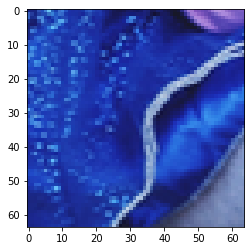

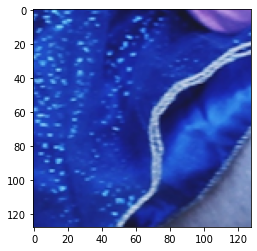

In [ ]:
# Mini-batch images and labels.
images = next(iter(train_loader))
inp = images[0]
lbl = images[1]
image = inp[0,:,:,:]
image2 = lbl[0,:,:,:]
RGB_img = cv2.cvtColor(image.permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(image2.permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()
plt.imshow(RGB_img2)
plt.show()

In [ ]:
# 2-Convolution + 2-Batch Normnalization + PReLU + ElementWise Sum for the generator
class residualBlock(nn.Module):
  def __init__(self,in_channels=64, k=3, n=64, s=1):
    super(residualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, n, k, stride=s, padding=1)
    self.bn1 = nn.BatchNorm2d(n)
    self.conv2 = nn.Conv2d(n, n, k, stride=s, padding=1)
    self.bn2 = nn.BatchNorm2d(n)  

    self.PReLU = nn.PReLU()

  def forward(self,x):
    result = self.PReLU(self.bn1(self.conv1(x)))
    return self.bn2(self.conv2(result)) + x

# Convolution + Batch Normalization + ElementWise Sum for the generator
class residualBlock2(nn.Module):
  def __init__(self,in_channels=64, k=3, n=64, s=1):
    super(residualBlock2, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, n, k, stride=s, padding=1)
    self.bn1 = nn.BatchNorm2d(n)

  def forward(self ,x):
    return self.bn1(self.conv1(x))

# Convolution + PixelShuffler x2 + PReLU for the generator
class ConvPixelShufflerPReLU(nn.Module):
  def __init__(self,in_channels=64):
    super(ConvPixelShufflerPReLU, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, in_channels * (2**2), 3, stride=1, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(2) ##UpscaleFactor 2
 
    self.PReLU = nn.PReLU()

  def forward(self ,x):
    result = self.pixel_shuffle(self.conv1(x))
    return self.PReLU(result)

# Convolution + Batch Normalization + LReLU for the generator
class ConvBNLReLU(nn.Module):
  def __init__(self,in_channels=64, n=64, s=2):
    super(ConvBNLReLU, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, n, 3, stride=s, padding=1)
    self.bn = nn.BatchNorm2d(n)
 
    self.LReLU = nn.LeakyReLU(0.2)

  def forward(self ,x):
    result = self.bn(self.conv1(x))
    return self.LReLU(result)  

### Encoder/Decoder 

(1) The **encoder** is composed of a first convolutional layer with small 3×3 kernel and 64 feature map, followed by a LReLU activation function (α= 0.2), 7 blocks composed of a convolution + batch normalization + LReLU layers. Each convolutional layer with an increasing number of 3×3 filter kernels, increasing by a factor of 2 from 64 to 512 kernels. (Strided convolutions areused to reduce the image resolution each time the numberof features is doubled)

(2) The **decoder** is used to estimate for a given Low Resolutin input Image its corresponding HR counterpart.
It is composed of a first convolutional layer with a bigger 9×9 kernel and 64 feature map, followed by a ParametricReLU activation function. After that first block, the tensor is passed through 5 Residual BLocks with identical layout. Each block consists of two convolutional layers with small 3×3 kernels and 64 feature maps followed by batch-normalization layer and a Parametric ReLU as the activation function.
And at the end of it, we use an extra residual block with a single convolutional layer, batch-normalization, and an elementwise sum of the first block. 
An upscaling block is used to increase the size, with 2 trained sub-pixel convolutional layers.

In [ ]:
###### ENCODER & DECODER ###### 
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
    self.LReLU = nn.LeakyReLU(0.2)

    self.layer1 = ConvBNLReLU(in_channels=64, n=64, s=2) #32x32
    self.layer2 = ConvBNLReLU(in_channels=64, n=128, s=1)
    self.layer3 = ConvBNLReLU(in_channels=128, n=128, s=2) #16x16
    self.layer4 = ConvBNLReLU(in_channels=128, n=256, s=1)
    self.layer5 = ConvBNLReLU(in_channels=256, n=256, s=2) #8x8
    self.layer6 = ConvBNLReLU(in_channels=256, n=512, s=1)
    self.layer7 = ConvBNLReLU(in_channels=512, n=512, s=2) #4x4
  
  def forward(self,x):
    out = self.LReLU(self.conv1(x))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    out = self.layer7(out)
    return out
    
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 9, stride=1, padding=4)
    self.PReLU = nn.PReLU()

    self.resBlock5 = residualBlock()
    self.resBlock4 = residualBlock()
    self.resBlock3 = residualBlock()
    self.resBlock2 = residualBlock()
    self.resBlock1 = residualBlock()

    self.resBlock_2 = residualBlock2()

    self.pixelShuff2 = ConvPixelShufflerPReLU() 
    self.pixelShuff1 = ConvPixelShufflerPReLU()

    self.conv2 = nn.Conv2d(64, 3, 9, stride=1, padding=4)
  
  def forward(self,x):
    out = self.PReLU(self.conv1(x))
    res = self.resBlock1(self.resBlock2(self.resBlock3(self.resBlock4(self.resBlock5(out)))))
    res2 = self.resBlock_2(res) + out
    res3 = self.pixelShuff1(res2)
    y = self.conv2(res3)
    tt = (torch.tanh(y) + 1) / 2
    return tt

###### DISCRIMINATOR & GENERATOR ######
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.classifier = Encoder()

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.classifier(x)
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

class Generator(nn.Module):
  def __init__(self,in_features,base_channels=3):
    super(Generator, self).__init__()
    self.decoder = Decoder()
    
  # Generate an image from vector z
  def forward(self,z):
    return self.decoder(z)

# TRAINING SRGAN


To train our model, we ask the **Generator** to generate a Super Resolution image from a Low Resolution one, and pass it to the **Discriminator** together with the High Resolution image, so that it can decide wich one is the Real.

Our perceptual loss function consist of a **Content Loss** which computes the pixel-wise MSE loss between both images + an **Adversarial Loss**  based  on  the  probabilities  of  the  discriminator.

In [ ]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc,
              num_epochs=10, model_name='SRGAN_50ep_06_02.ckpt', device='cpu'):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []
    msel = nn.MSELoss()
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (LR_images, HR_images) in enumerate(train_loader):
            # Get batch of samples and labels
            #print(real_images[0,:,:,:].shape)
            LR_images = LR_images.to(device)
            HR_images = HR_images.to(device)
            n_images = LR_images.shape[0]

            # Generate SR images           
            SR_images = gen.forward(LR_images)

            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_HR = disc(HR_images).mean()
            prob_SR = disc(SR_images).mean()            
           
            # Discriminator loss
            disc_loss = 1 - prob_HR + prob_SR
            disc_loss.backward(retain_graph=True)

            # Generator loss
            content_loss = msel(SR_images, HR_images)
            adversarial_loss = -torch.log(prob_SR).mean()
            gen_loss = content_loss + 0.001*adversarial_loss

            # We are going to update the discriminator and generator parameters alternatively at each iteration

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        

        # For every 10 epochs: Plot the LR-HR-SR images of the training resoults
        if (epoch+1) % 10 == 0:
          image = LR_images.cpu()[0,:,:,:]
          RGB_img = cv2.cvtColor(image.permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
          plt.imshow(RGB_img)
          plt.show()
          
          image1 = HR_images.cpu()[0,:,:,:]
          RGB_img1 = cv2.cvtColor(image1.permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
          plt.imshow(RGB_img1)
          plt.show()

          image2 = SR_images.cpu()[0,:,:,:]
          RGB_img2 = cv2.cvtColor(image2.permute(1,2,0).squeeze().detach().numpy(), cv2.COLOR_BGR2RGB)
          plt.imshow(RGB_img2)
          plt.show()
            
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)
    
    # Plot the LR-HR-SR images of the las training resoults
    '''image = LR_images.cpu()[0,:,:,:]
    plt.imshow(image.permute(1,2,0).squeeze().detach().numpy())
    plt.show()
    
    image1 = HR_images.cpu()[0,:,:,:]
    plt.imshow(image1.permute(1,2,0).squeeze().detach().numpy())
    plt.show()

    image2 = SR_images.cpu()[0,:,:,:]
    plt.imshow(image2.permute(1,2,0).squeeze().detach().numpy())
    plt.show() '''
    return losses_list 

Epoch [1/50], Step [101/101], Gen. Loss: 0.0127, Disc Loss: 0.9827
Epoch [2/50], Step [101/101], Gen. Loss: 0.0073, Disc Loss: 0.9609
Epoch [3/50], Step [101/101], Gen. Loss: 0.0064, Disc Loss: 0.9412
Epoch [4/50], Step [101/101], Gen. Loss: 0.0050, Disc Loss: 0.9239
Epoch [5/50], Step [101/101], Gen. Loss: 0.0046, Disc Loss: 0.9163
Epoch [6/50], Step [101/101], Gen. Loss: 0.0048, Disc Loss: 0.9108
Epoch [7/50], Step [101/101], Gen. Loss: 0.0049, Disc Loss: 0.9205
Epoch [8/50], Step [101/101], Gen. Loss: 0.0067, Disc Loss: 0.9092
Epoch [9/50], Step [101/101], Gen. Loss: 0.0055, Disc Loss: 0.9054
Epoch [10/50], Step [101/101], Gen. Loss: 0.0039, Disc Loss: 0.9004


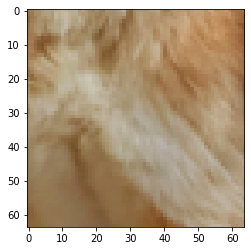

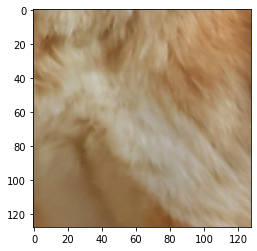

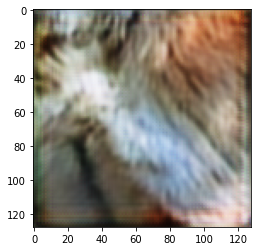

Epoch [11/50], Step [101/101], Gen. Loss: 0.0039, Disc Loss: 0.9146
Epoch [12/50], Step [101/101], Gen. Loss: 0.0042, Disc Loss: 0.9055
Epoch [13/50], Step [101/101], Gen. Loss: 0.0035, Disc Loss: 0.8973
Epoch [14/50], Step [101/101], Gen. Loss: 0.0039, Disc Loss: 0.8941
Epoch [15/50], Step [101/101], Gen. Loss: 0.0034, Disc Loss: 0.8931
Epoch [16/50], Step [101/101], Gen. Loss: 0.0039, Disc Loss: 0.8919
Epoch [17/50], Step [101/101], Gen. Loss: 0.0032, Disc Loss: 0.8919
Epoch [18/50], Step [101/101], Gen. Loss: 0.0033, Disc Loss: 0.8884
Epoch [19/50], Step [101/101], Gen. Loss: 0.0037, Disc Loss: 0.8871
Epoch [20/50], Step [101/101], Gen. Loss: 0.0037, Disc Loss: 0.8857


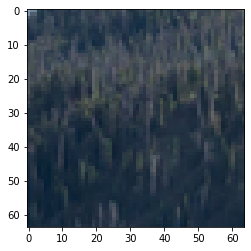

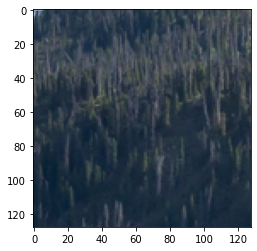

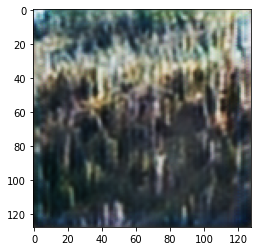

Epoch [21/50], Step [101/101], Gen. Loss: 0.0035, Disc Loss: 0.8838
Epoch [22/50], Step [101/101], Gen. Loss: 0.0027, Disc Loss: 0.8818
Epoch [23/50], Step [101/101], Gen. Loss: 0.0027, Disc Loss: 0.8821
Epoch [24/50], Step [101/101], Gen. Loss: 0.0032, Disc Loss: 0.8812
Epoch [25/50], Step [101/101], Gen. Loss: 0.0030, Disc Loss: 0.8806
Epoch [26/50], Step [101/101], Gen. Loss: 0.0026, Disc Loss: 0.8790
Epoch [27/50], Step [101/101], Gen. Loss: 0.0026, Disc Loss: 0.8780
Epoch [28/50], Step [101/101], Gen. Loss: 0.0026, Disc Loss: 0.8769
Epoch [29/50], Step [101/101], Gen. Loss: 0.0027, Disc Loss: 0.8760
Epoch [30/50], Step [101/101], Gen. Loss: 0.0052, Disc Loss: 0.8745


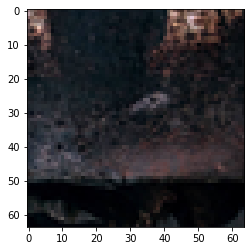

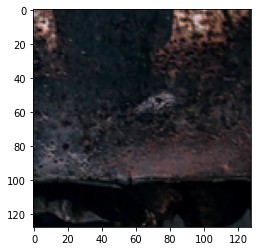

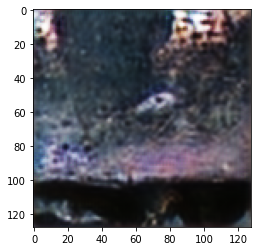

Epoch [31/50], Step [101/101], Gen. Loss: 0.0032, Disc Loss: 0.8728
Epoch [32/50], Step [101/101], Gen. Loss: 0.0030, Disc Loss: 0.8734
Epoch [33/50], Step [101/101], Gen. Loss: 0.0033, Disc Loss: 0.8718
Epoch [34/50], Step [101/101], Gen. Loss: 0.0027, Disc Loss: 0.8707
Epoch [35/50], Step [101/101], Gen. Loss: 0.0029, Disc Loss: 0.8705
Epoch [36/50], Step [101/101], Gen. Loss: 0.0037, Disc Loss: 0.8685
Epoch [37/50], Step [101/101], Gen. Loss: 0.0027, Disc Loss: 0.8677
Epoch [38/50], Step [101/101], Gen. Loss: 0.0028, Disc Loss: 0.8681
Epoch [39/50], Step [101/101], Gen. Loss: 0.0028, Disc Loss: 0.8660
Epoch [40/50], Step [101/101], Gen. Loss: 0.0025, Disc Loss: 0.8751


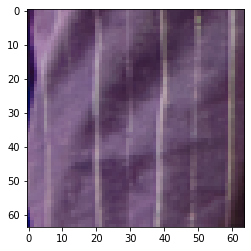

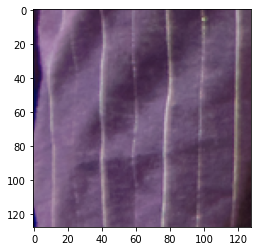

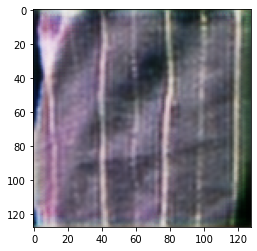

Epoch [41/50], Step [101/101], Gen. Loss: 0.0022, Disc Loss: 0.9282
Epoch [42/50], Step [101/101], Gen. Loss: 0.0022, Disc Loss: 0.9017
Epoch [43/50], Step [101/101], Gen. Loss: 0.0023, Disc Loss: 0.8773
Epoch [44/50], Step [101/101], Gen. Loss: 0.0023, Disc Loss: 0.8727
Epoch [45/50], Step [101/101], Gen. Loss: 0.0026, Disc Loss: 0.8740


In [ ]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(64)
gan_disc = Discriminator()

#Initialize indepdent optimizer for both networks
learning_rate = .0005
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = 0.0006, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = 0.0002, weight_decay=1e-5)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc,
                      num_epochs=50, model_name='SRGAN_50ep_06_02.ckpt', device=device)

#TESTING SRGAN

Once our model has been trained, we can Test the resoults by using the generated CKPT file.
To do so we create another Data class which loads LR images never seen by our model.

In [ ]:
class DataTest(torch.utils.data.Dataset):
      # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'dataTest.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)   # Load the mat file containing the dataset
        self.data = mat_loaded['X']         # Store the low resolution images in a variable data
        self.transform = transform          # Determine a transform if needed

     # What to do to load a single item in the dataset ( read image)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]             # Get the specified LR image
        data = Image.fromarray(data,mode='RGB')   # transform the LR image to array  
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data
    
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

tr = tf.Compose([
        tf.ToTensor(), # convert image to pytorch tensor [0..,1]
        ])

# Load the Test Dataset from th e specified .mat
datasetTest = DataTest(data_path+'dataTest.mat',tr)   
test_loader = torch.utils.data.DataLoader(dataset=datasetTest,
                                               batch_size=1, 
                                               shuffle=True)
# Load generator
gan_gen = Generator(64)
gan_gen.load_state_dict(torch.load(results_path+'/gan_mnist.ckpt'))
gan_gen.eval() # Put in eval model
gan_gen = gan_gen.to(device)

# From every Image in the Test Dataset, we generate a SR image.
for i, LR_images in enumerate(test_loader):
    LR_images = LR_images.to(device)

    # Generate SR images           
    SR_images = gen.forward(LR_images)

    # Plot Low Resolution Image (original)
    LR = LR_images.cpu()[0,:,:,:]
    RGB_LR = LR.permute(1,2,0).squeeze().detach().numpy()
    cv2.imwrite(results_path + "TestImages/LR" + str(i) + ".png", RGB_LR)
    plt.imshow(RGB_LR)
    plt.show()

    # Plot Super Resolution Image (Fake)
    SR = SR_images.cpu()[0,:,:,:]
    RGB_SR = SR.permute(1,2,0).squeeze().detach().numpy()
    cv2.imwrite(results_path + "TestImages/SR" + str(i) + ".png", RGB_SR)
    plt.imshow(RGB_SR)
    plt.show()